# Source Code

## 0. Overview

This source code provides a detailed pipeline of gathering data from Reddit and the stock market, cleaning it, performing sentiment analysis, and graphing the results.

Please run the following cell, as most future code blocks utilize the libraries included below:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

## 1.1. Data Gathering - Reddit

This section of code is used to gather reddit data. PMAW is used, and can be found at [https://github.com/mattpodolak/pmaw ](https://github.com/mattpodolak/pmaw ).

**NOTE:** If gathering data, this should be run as a local jupyter notebook instead of on Google Colab, since the file size will be too large.

In [2]:
!pip install pmaw

In [3]:
from pmaw import PushshiftAPI

In [4]:
def getRedditData(subreddit, output_file, is_posts, content_limit=100000):
  '''
  A function to get content (either posts or comments) 
  from a subreddit and save it to a csv file
  '''
  api = PushshiftAPI()
  # get posts
  if is_posts is True:
    content = api.search_submissions(subreddit=subreddit, limit=content_limit)
  # get comments
  else:
    content = api.search_comments(subreddit=subreddit, limit=content_limit)
  # save content to dataframe
  content_df = pd.DataFrame(content)
  # write output csv
  content_df.to_csv(output_file, header=True, index=False, columns=list(content_df.axes[1]))

  return content_df

## 1.2. Data Gathering - Finance

This section of code is used to gather stock price data. For this, yfinance is used, info for which can be found at [https://pypi.org/project/yfinance/](https://pypi.org/project/yfinance/).

**NOTE:** If gathering data, this should be run as a local jupyter notebook instead of on Google Colab, since the file size will be too large.

In [5]:
!pip install yfinance

In [6]:
import yfinance as yf

In [7]:
def getFinanceData(stock_name, output_file, start_date, end_date):
  # get stock prices
  msft = yf.Ticker(stock_name)
  hist = msft.history(period="max")
  data = yf.download(stock_name, start=start_date, end=end_date)
  # fix date as a column
  data.insert(0, 'Date', data.index)
  data.reset_index(drop=True, inplace=True)
  data['Date'] = data['Date'].astype(str)
  # write output csv
  data.to_csv(output_file, header=True, index=False, columns=list(data.axes[1]))
  return data

## 2. Data Cleaning

After getting the data, this section of code cleans the data and reduces it to only the usable (graphable) values.

In [8]:
def cleanTimestamps(df):

  # remove posts with invalid timestamps
  df = df.dropna(subset=['created_utc'])
  null_df = df.created_utc.isnull()
  df = df[null_df == False]
  df = df[df.created_utc != "[deleted]"]
  df = df[df.created_utc != "[removed]"]

  # remove incorrectly formatted timestamps
  rows_to_keep = []
  with tqdm(total=len(df)) as pbar:
    for i in range(len(df)):
      rows_to_keep.append(not isinstance(df.iloc[i].created_utc, str))
      pbar.update(1)
  df = df[rows_to_keep]

  # create formatted timestamps
  sub_dates = []
  for time in df['created_utc']:
    fts = datetime.utcfromtimestamp(time).strftime('%Y-%m-%d')
    sub_dates.append(fts)

  # append new timestamps
  df['Date'] = sub_dates
  df = df.sort_values(by=['Date'])

  return df

In [9]:
def cleanRedditPosts(input_file, output_file, input_df=None):

  # get input data
  if input_df.empty:
    posts_df = pd.read_csv(input_file)
  else:
    posts_df = input_df.copy()

  # remove invalid posts
  null_posts_df = posts_df.selftext.isnull()
  posts_df = posts_df[null_posts_df == False]
  posts_df = posts_df[posts_df.selftext != "[deleted]"]
  posts_df = posts_df[posts_df.selftext != "[removed]"]

  # remove posts whose content is too long
  posts_df = posts_df[posts_df.selftext.apply(lambda x: len(str(x)) < 512)]

  # clean timestamps
  posts_df = cleanTimestamps(posts_df)

  # write output csv
  posts_df.to_csv(output_file, header=True, index=False, columns=list(posts_df.axes[1]))

  return posts_df

In [10]:
def cleanRedditComments(input_file, output_file, input_df=None):

  # get input data
  if input_df.empty:
    comments_df = pd.read_csv(input_file)
  else:
    comments_df = input_df.copy()

  # remove invalid posts
  null_comments_df = comments_df.body.isnull()
  comments_df = comments_df[null_comments_df == False]
  comments_df = comments_df[comments_df.body != "[deleted]"]
  comments_df = comments_df[comments_df.body != "[removed]"]

  # remove posts whose content is too long
  comments_df = comments_df[comments_df.body.apply(lambda x: len(str(x)) < 512)]

  # clean timestamps
  comments_df = cleanTimestamps(comments_df)

  # write data to csv
  comments_df.to_csv(output_file, header=True, index=False, columns=list(comments_df.axes[1]))

  return comments_df

## 3. Sentiment Analysis

This section of code is used to perform sentiment analysis on the reddit content.

In [11]:
# !pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch

In [12]:
!pip install transformers requests beautifulsoup4 pandas numpy

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

In [14]:
def getSentiment(input_file, output_file, is_posts, input_df=None):

  # get input data
  if input_df.empty:
     df = pd.read_csv(input_file)
  else:
    df = input_df.copy()

  # create new sentiment column
  df['Sentiment'] = ""

  # instantiate model
  tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
  model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

  # perform sentiment analysis
  with tqdm(total=len(df)) as pbar:
    for i in range(len(df)):
      tokens = []
      # analyze post
      if is_posts is True:
        tokens = tokenizer.encode(df.iloc[i].selftext, return_tensors='pt')
      # analyze comment
      else:
        tokens = tokenizer.encode(df.iloc[i].body, return_tensors='pt')
      result = model(tokens)
      # df['Sentiment'].iloc[i] = (int(torch.argmax(result.logits))+1)
      df['Sentiment'].iloc[i] = (int(torch.argmax(result.logits))+1)
      pbar.update(1)

  # write output file
  df.to_csv(output_file, header=True, index=False, columns=list(df.axes[1]))

  return df

## 4. Data Selection for Graphing

This section of code performs final preparations on the data, getting it ready to be graphed. After data cleaning, the number of data points per day is not consistent between datasets, so this code handles that.

In [15]:
from statistics import mean

In [16]:
def averageDailySentiment(df):

  # iterate over data, counting frequency of dates
  sentiment_dict = {}
  for i in range(len(df)):
    key = df.loc[i,'Date']
    value = df.loc[i,'Sentiment']
    # add new dates to dict
    if key not in sentiment_dict:
      sentiment_dict[key] = [value]
    # update count of existing dates
    else:
      sentiment_dict[key].append(value)

  dates=[]
  sentiments=[]

  # create new dataframe with daily average sentiment
  for key in sentiment_dict:
    value = mean([float(x) for x in sentiment_dict[key]])
    value = int(round(value))
    dates.append(key)
    sentiments.append(value)

  df = pd.DataFrame(list(zip(dates, sentiments)), columns=['Date', 'Sentiment'])

  return df

In [43]:
def getDateAndSentiment(input_file, output_file, input_df=None):
  # get input data
  try:
    if input_df is None:
      raw_df = pd.read_csv(input_file)
  except: # ValueError:
    if input_df.empty:
      raw_df = pd.read_csv(input_file)
  finally:
    raw_df = input_df.copy()
    raw_df.reset_index(drop=True, inplace=True)
  # create new df with just dates and sentiment
  filtered_df = raw_df[['Date', 'Sentiment']].copy()
  # average the daily sentiment
  filtered_df = averageDailySentiment(filtered_df)
  # write output csv
  filtered_df.to_csv(output_file, header=True, index=False, columns=list(filtered_df.axes[1]))
  return filtered_df

In [18]:
def getUsableData(sentiment_input_file, finance_input_file, 
                  sentiment_output_file, finance_output_file, 
                  sentiment_input_df=None, finance_input_df=None):

  # get sentiment input data
  if sentiment_input_df.empty:
    sentiment_df = pd.read_csv(sentiment_input_file)
  else:
    sentiment_df = sentiment_input_df.copy()
  
  # get finance input data
  if finance_input_df.empty:
    finance_df = pd.read_csv(finance_input_file)
  else:
    finance_df = finance_input_df.copy()

  # get list of dates
  sentiment_dates = list(sentiment_df.loc[:,'Date'])
  finance_dates = list(finance_df.loc[:,'Date'])

  # find date overlaps
  usable_dates = []
  for i in range(len(sentiment_dates)):
    if sentiment_dates[i] in finance_dates:
      usable_dates.append(sentiment_dates[i])
  
  # print(sentiment_dates)
  # print()
  # print()
  # print(finance_dates)

  # create graphable sentiment dataframe
  sentiment_list = []
  for i in range(len(sentiment_df)):
    date = sentiment_df.loc[i,'Date']
    sentiment = sentiment_df.loc[i,'Sentiment']
    if date in usable_dates:
      sentiment_list.append((date,sentiment))
  graphable_sentiment_df = pd.DataFrame(sentiment_list, columns=['Date','Sentiment'])

  # create graphable finance dataframe
  finance_list = []
  for i in range(len(finance_df)):
    date = finance_df.loc[i,'Date']
    price = finance_df.loc[i,'Close']
    if date in usable_dates:
      finance_list.append((date,price))
  graphable_finance_df = pd.DataFrame(finance_list, columns=['Date','Price'])

  # write output csv
  graphable_sentiment_df.to_csv(sentiment_output_file, header=True, index=False, columns=list(graphable_sentiment_df.axes[1]))
  graphable_finance_df.to_csv(finance_output_file, header=True, index=False, columns=list(graphable_finance_df.axes[1]))

  return graphable_sentiment_df, graphable_finance_df

## 5. ASAP Open Source Data Smoothing

This section of code is the open-source code for the ASAP data smoothing API. Slight modifications were made to make it python3-compatible.

In [19]:
import sys
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import pandas as pd
import json
import numpy.fft
from decimal import Decimal
import math

%matplotlib inline

In [20]:
# ASAP Simple (Brute Force)
def moving_average(data, _range):
    ret = np.cumsum(data, dtype=float)
    ret[_range:] = ret[_range:] - ret[:-_range]
    return ret[_range - 1:] / _range

def SMA(data, _range, slide):
    ret = moving_average(data, _range)[::slide]
    return list(ret)

def kurtosis(values):
    return scipy.stats.kurtosis(values)

def roughness(vals):
    return np.std(np.diff(vals))

def smooth_simple(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    window_size = 1
    slide_size = 1
    if resolution:
        slide_size = int(len(data) / resolution)
        if slide_size > 1:
            data = SMA(data, slide_size, slide_size)
    orig_kurt   = kurtosis(data)
    min_obj     = roughness(data)
    max_window = int(max_window) #ADDED LINE
    for w in range(2, int(len(data) / max_window + 1)): #ADDED INT CASTING
        smoothed = SMA(data, w, 1)
        if kurtosis(smoothed) >= orig_kurt:
            r = roughness(smoothed)
            if r < min_obj:
                min_obj = r
                window_size = w
    return window_size, slide_size

In [21]:
# ASAP
class Metrics(object):
    def __init__(self, values):
        self.set_values( values )

    def set_values(self, values):
        self.values = values
        self.r = self.k = None

    @property
    def kurtosis(self):
        if self.k is None:
            self.k = scipy.stats.kurtosis(self.values)
        return self.k

    @property
    def roughness(self):
        if self.r is None:
            self.r = np.std(np.diff(self.values))
        return self.r

class ACF(Metrics):
    CORR_THRESH = 0.2
    def __init__(self, values, max_lag=None):
        super(ACF, self).__init__(values)
        if max_lag is None:
            max_lag = len(values) / 5
        self.max_lag = int(max_lag)
        self.max_acf = 0.0

        # Calculate autocorrelation via FFT
        # Demean
        demeaned = values - np.mean(values)
        # Pad data to power of 2 
        l = int(2.0 ** (int(math.log(len(demeaned),2.0)) + 1))
        padded = np.append(demeaned, ([0.0] * (l - len(demeaned))))    
        # FFT and inverse FFT
        F_f = numpy.fft.fft( padded )
        R_t = numpy.fft.ifft( F_f * np.conjugate(F_f) )
        max_lag = int(max_lag) #ADDED LINE
        self.correlations = R_t[:max_lag].real / R_t[0].real
        
        # Find autocorrelation peaks 
        self.peaks = []
        if len(self.correlations) >1 :
            positive = self.correlations[1] > self.correlations[0]
            max = 1
            for i in range(2, len(self.correlations)):
                if not positive and self.correlations[i] > self.correlations[i-1]:
                    max = i
                    positive = not positive
                elif positive and self.correlations[i] > self.correlations[max]:
                    max = i
                elif positive and self.correlations[i] < self.correlations[i-1]:
                    if max > 1 and self.correlations[max] > self.CORR_THRESH:
                        self.peaks.append(max)
                        if self.correlations[max] > self.max_acf:
                            self.max_acf = self.correlations[max]
                    positive = not positive
        # If there is no autocorrelation peak within the MAX_WINDOW boundary,
        # try windows from the largest to the smallest 
        if len(self.peaks) <= 1:
            self.peaks = range(2, len(self.correlations))
                    
def moving_average(data, _range):
    ret = np.cumsum(data)
    _range = int(_range) #ADDED LINE
    ret[_range:] = ret[_range:] - ret[:-_range]
    return ret[_range - 1:] / _range

def SMA(data, _range, slide):
    _range = int(_range) #ADDED LINE
    slide = int(slide) #ADDED LINE
    ret = moving_average(data, _range)[::slide]
    return list(ret)
                    
def binary_search(head,tail,data,min_obj,orig_kurt,window_size):
    while head <= tail:
        w = int(round((head + tail) / 2.0))
        smoothed = SMA(data,w,1)
        metrics  = Metrics(smoothed)
        if metrics.kurtosis >= orig_kurt:
            if metrics.roughness < min_obj:
                window_size = w
                min_obj = metrics.roughness
            head = w + 1
        else:
            tail = w - 1
    return window_size

def smooth_ASAP(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    slide_size = 1
    window_size = 1
    if resolution and len(data) >= 2 * resolution:
        slide_size = len(data) / resolution
        data = SMA(data, slide_size, slide_size)
    acf         = ACF(data, max_lag=len(data) / max_window)
    peaks       = acf.peaks
    orig_kurt   = acf.kurtosis
    min_obj     = acf.roughness
    lb          = 1
    largest_feasible = -1
    tail = len(data) / max_window
    for i in range(len(peaks) - 1, -1, -1):
        w = peaks[i]

        if w < lb or w == 1:
            break
        elif math.sqrt(1 - acf.correlations[w]) * window_size > math.sqrt(1 - acf.correlations[window_size]) * w:
            continue

        smoothed = SMA(data, w, 1)
        metrics = Metrics(smoothed)
        if metrics.roughness < min_obj and metrics.kurtosis >= orig_kurt:
            min_obj = metrics.roughness
            window_size = w
            lb = round( max(w*math.sqrt( (acf.max_acf -1) / (acf.correlations[w]-1) ), lb) )
    if largest_feasible > 0:
        if largest_feasible < len(peaks) - 2:
            tail = peaks[largest_feasible + 1]
        lb = max(lb, peaks[largest_feasible] + 1)

    window_size = binary_search(lb, tail, data, min_obj, orig_kurt, window_size)
    return window_size, slide_size

In [22]:
# Read data from CSV
def load_csv(fname, input_column=1):
    import csv
    with open(fname, 'r') as ifh:
        icsv = csv.reader(ifh)
        if sys.version_info.major == 2:
            header = icsv.next()
        else:
            header = next(icsv)
        rows = list(icsv)

        try:
            data = [ float(x[input_column]) for x in rows ]
        except ValueError:
            print("couldn't convert input-column={0} float".format(input_column))
            if rows:
                print("first row:")
                for idx,x in enumerate(rows[0]):
                    print('  column {:3d}: {}'.format(idx,x))
            exit(1)
    return data

In [23]:
# Plot time series before and after smoothing
def plot(data, window_size, slide_size):
    plt.clf()
    plt.figure()
    data = SMA(data, slide_size, slide_size)
    method_names = ["Original", "Smoothed"]
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    smoothed = SMA(data, window_size, 1)
    smoothed_range = range(int(window_size/2), int(window_size/2) + len(smoothed))
    ax1.set_xlim(0, len(data))
    ax1.plot(data, linestyle='-', linewidth=1.5)
    ax2.plot(smoothed_range, smoothed, linestyle='-', linewidth=1.5)
    axes = [ax1, ax2]
    for i in range(2):
        axes[i].get_xaxis().set_visible(False)
        axes[i].text(0.02, 0.8, "%s" %(method_names[i]),
            verticalalignment='center', horizontalalignment='left',
            transform=axes[i].transAxes, fontsize=25)

    fig.set_size_inches(16, 6)
    plt.tight_layout(w_pad=1)
    plt.show()

## 6. Final Graphing

This was code we added to utilize the ASAP API and produce graphs with the smoothed sentiment data.

In [24]:
#https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html

# Plot time series of two different sets of data
def plot_multiple(dataToSmooth, dataToCompare, window_size, slide_size):
    temp = SMA(dataToSmooth, slide_size, slide_size)
    smoothed = SMA(temp, window_size, 1)
    smoothed_range = range(int(window_size/2), int(window_size/2) + len(smoothed))
    
    # print(smoothed_range)

    fig, ax1 = plt.subplots()

    color1 = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Sentiment', color=color1)
    ax1.plot(smoothed_range, smoothed, color=color1, linestyle='-', linewidth=1.5)
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color2 = 'tab:blue'
    ax2.set_ylabel('Stock Price', color=color2)  # we already handled the x-label with ax1
    ax2.plot(dataToCompare, color=color2, linestyle='-', linewidth=1.5)
    ax2.tick_params(axis='y', labelcolor=color2)

    # for i in []:
    #   plt.axvline(i, color='black')

    fig.tight_layout(w_pad=1)  # otherwise the right y-label is slightly clipped
    fig.set_size_inches(16, 6)
    plt.show()

In [25]:
def sentimentVsFinance(sentiment_input_file, finance_input_file, normalize_finance=False):
  # load data
  sentiment_data = load_csv(sentiment_input_file)
  sentiment_data_int = [int(a) for a in sentiment_data]
  finance_data = load_csv(finance_input_file)
  # normalize stock prices
  if normalize_finance == True:
    finance_data = [np.log(x) for x in finance_data]
  # graph data
  window_size, slide_size = smooth_ASAP(sentiment_data_int, resolution=1920)
  # print("Window Size: ", window_size)
  plot_multiple(sentiment_data, finance_data, window_size, slide_size)

# Driver Code

#### Post Sentiment

In [26]:
# Get reddit data
raw_reddit_posts_df = getRedditData('Disney', 'raw_disney_posts.csv', is_posts=True, content_limit=1000)

INFO:pmaw.PushshiftAPIBase:Total:: Success Rate: 100.00% - Requests: 10 - Batches: 1 - Items Remaining: 0


In [27]:
# Get stock data
raw_finance_df = getFinanceData('DIS', 'raw_finance.csv', '2000-01-01', '2021-11-15')

INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
[*********************100%***********************]  1 of 1 completed


In [28]:
# Clean reddit data
cleaned_reddit_posts_df = cleanRedditPosts('', 'cleaned_disney_posts.csv', raw_reddit_posts_df)

100%|██████████| 703/703 [00:00<00:00, 11024.52it/s]


In [29]:
# Perform sentiment analysis on reddit data
reddit_posts_and_sentiment_df = getSentiment('', 'disney_posts_w_sentiment.csv', True, cleaned_reddit_posts_df)

  0%|          | 0/703 [00:00<?, ?it/s]/Users/keeks/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
100%|██████████| 703/703 [00:20<00:00, 34.28it/s]


In [34]:
# Filter reddit data
reddit_sentiment_df = getDateAndSentiment('', 'disney_sentiment.csv', reddit_posts_and_sentiment_df)

In [35]:
# Get graphable data files
graphable_sentiment, graphable_finance = getUsableData('', '', 'graphable_sentiment.csv', 'graphable_finance.csv', reddit_sentiment_df, raw_finance_df)

/var/folders/db/6lkxg6fn7219f1vx45rkdbjm0000gn/T/ipykernel_5631/1146600579.py:41: RuntimeWarning: invalid value encountered in true_divide
  self.correlations = R_t[:max_lag].real / R_t[0].real


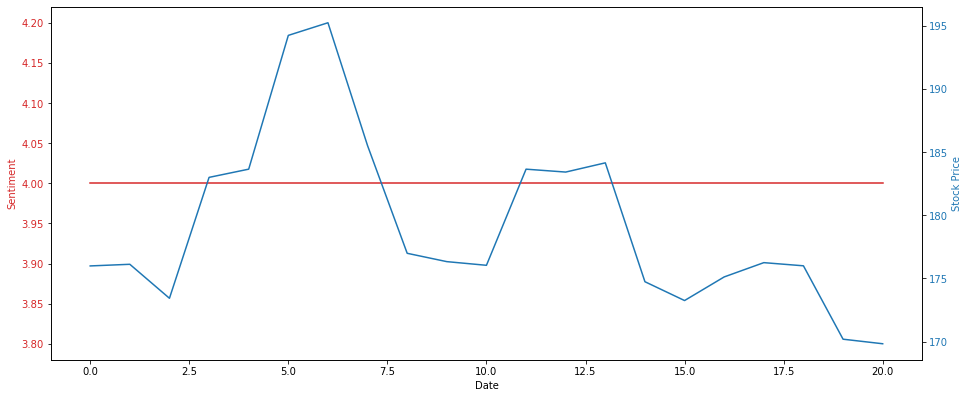

In [36]:
# Graph data
sentimentVsFinance('graphable_sentiment.csv', 'graphable_finance.csv')

#### Comment Sentiment

In [44]:
# This does the same as the above cells, but for comments instead of posts
raw_reddit_comments_df = getRedditData('Disney', 'raw_disney_comments.csv', is_posts=False, content_limit=1000)
raw_finance_df = getFinanceData('DIS', 'raw_finance.csv', '2000-01-01', '2021-11-15')
cleaned_reddit_comments_df = cleanRedditComments('', 'cleaned_disney_comments.csv', raw_reddit_comments_df)
reddit_comments_and_sentiment_df = getSentiment('', 'disney_comments_w_sentiment.csv', False, cleaned_reddit_comments_df)
reddit_sentiment_df = getDateAndSentiment('disney_comments_w_sentiment.csv', 'disney_sentiment.csv')
graphable_sentiment, graphable_finance = getUsableData('', '', 'graphable_sentiment.csv', 'graphable_finance.csv', reddit_sentiment_df, raw_finance_df)
sentimentVsFinance('graphable_sentiment.csv', 'graphable_finance.csv')
sentimentVsFinance('graphable_sentiment.csv', 'graphable_finance.csv', True)

INFO:pmaw.PushshiftAPIBase:Total:: Success Rate: 100.00% - Requests: 10 - Batches: 1 - Items Remaining: 0
[*********************100%***********************]  1 of 1 completed


  0%|          | 0/741 [00:00<?, ?it/s]/Users/keeks/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
100%|██████████| 741/741 [01:52<00:00,  6.59it/s]


AttributeError: 'NoneType' object has no attribute 'copy'